In [1]:
import torch
import sys
import os
sys.path.append('../vega/')
import vega
import scanpy as sc
import scvi
from scipy import sparse
import numpy as np
import gseapy as gp
import pandas as pd
torch.manual_seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib

path_to_save = '../paper/figures/vega_binary/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
font = {'family' : 'Arial',
        'size'   : 14}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
# Scanpy figures params
sc.set_figure_params(dpi_save=300)
sc.settings.figdir = path_to_save

In [2]:
model_binary = vega.VEGA.load('../trained_models/kang_binary_decoder/')
print(model_binary)
model_full = vega.VEGA.load('../trained_models/kang_vega/')
print(model_full)

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
VEGA model with the following parameters: 
n_GMVs: 675, dropout_rate:0.5, z_dropout:0.5, beta:0.0001, positive_decoder:True
Model is trained: True
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
VEGA model with the following parameters: 
n_GMVs: 675, dropout_rate:0.5, z_dropout:0.5, beta:0.0001, positive_decoder:True
Model is trained: True


In [3]:
model_binary.adata.obsm['X_vega'] = model_binary.to_latent(return_mean=True)
sc.pp.neighbors(model_binary.adata, use_rep='X_vega', n_neighbors=15)
sc.tl.umap(model_binary.adata, min_dist=0.5, random_state=42)

model_full.adata.obsm['X_vega'] = model_full.to_latent(return_mean=True)
sc.pp.neighbors(model_full.adata, use_rep='X_vega', n_neighbors=15)
sc.tl.umap(model_full.adata, min_dist=0.5, random_state=42)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


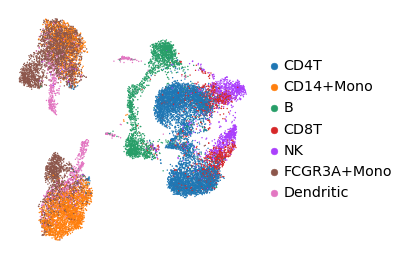

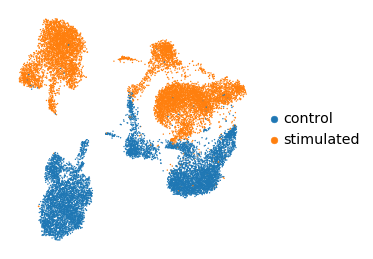

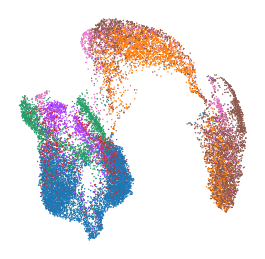

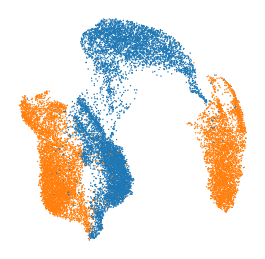

In [4]:
# sc.pl.umap(model_binary.adata,
#            color=['cell_type', 'condition'],
#            wspace=0.5,
#            title=['Cell Type', 'Condition'], save='_binary_model.pdf')

# sc.pl.umap(model_full.adata,
#            color=['cell_type', 'condition'],
#            wspace=0.5,
#            title=['Cell Type', 'Condition'], save='_full_model.pdf')

sc.pl.umap(model_full.adata, color='cell_type', title='', frameon=False, save='_full_ct.pdf')
sc.pl.umap(model_full.adata, color='condition', title='', frameon=False, save='_full_cond.pdf')
sc.pl.umap(model_binary.adata, color='cell_type', title='', frameon=False, legend_loc = None, save='_binary_ct.pdf')
sc.pl.umap(model_binary.adata, color='condition', title='', frameon=False, legend_loc = None, save='_binary_cond.pdf')

In [5]:
# Experiment with mask + PCA
adata_gmv = sc.AnnData(X=model_full.adata.X @ model_full.adata.uns['_vega']['mask'],
                       var=pd.DataFrame(index=model_full.adata.uns['_vega']['gmv_names']),
                       obs=model_full.adata.obs)
sc.pp.scale(adata_gmv)
sc.tl.pca(adata_gmv, n_comps=50)
sc.pp.neighbors(adata_gmv)
sc.tl.umap(adata_gmv)

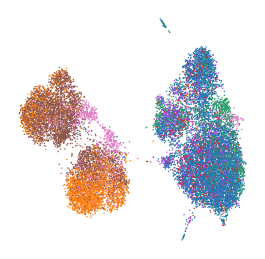

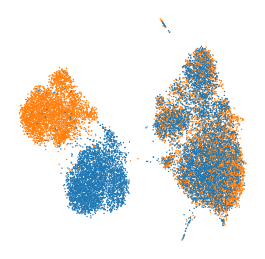

In [6]:
# sc.pl.umap(adata_gmv,
#            color=['cell_type', 'condition'],
#            wspace=0.5,
#            title=['Cell Type', 'Condition'], save='_mask+pca.pdf')
sc.pl.umap(adata_gmv, color='cell_type', title='', frameon=False, legend_loc = None, save='_mask_ct.pdf')
sc.pl.umap(adata_gmv, color='condition', title='', frameon=False, legend_loc = None, save='_mask_cond.pdf')

## Silhouette scores

In [7]:
from sklearn.metrics import silhouette_score

y_cond = model_full.adata.obs['cell_type']
y_ct_stim = model_full.adata.obs['cell_type'][model_full.adata.obs['condition']=='stimulated']
y_ct_ctrl = model_full.adata.obs['cell_type'][model_full.adata.obs['condition']=='control']

X = model_full.adata.obsm['X_vega']
asw_full_cond = silhouette_score(X, labels=y_cond)
asw_full_ct_stim = silhouette_score(X[adata_gmv.obs['condition']=='stimulated',:], labels=y_ct_stim)
asw_full_ct_ctrl = silhouette_score(X[adata_gmv.obs['condition']=='control',:], labels=y_ct_ctrl)

X = model_binary.adata.obsm['X_vega']
asw_binary_cond = silhouette_score(X, labels=y_cond)
asw_binary_ct_stim = silhouette_score(X[adata_gmv.obs['condition']=='stimulated',:], labels=y_ct_stim)
asw_binary_ct_ctrl = silhouette_score(X[adata_gmv.obs['condition']=='control',:], labels=y_ct_ctrl)

X = adata_gmv.obsm['X_pca']
asw_mask_cond = silhouette_score(X, labels=y_cond)
asw_mask_ct_stim = silhouette_score(X[adata_gmv.obs['condition']=='stimulated',:], labels=y_ct_stim)
asw_mask_ct_ctrl = silhouette_score(X[adata_gmv.obs['condition']=='control',:], labels=y_ct_ctrl)

In [13]:
# Plot ASW
vec = np.array([asw_mask_cond,
asw_mask_ct_ctrl,
asw_mask_ct_stim,
asw_binary_cond,
asw_binary_ct_ctrl,
asw_binary_ct_stim,
asw_full_cond,
asw_full_ct_ctrl,
asw_full_ct_stim])

df_res = pd.DataFrame()
df_res['ASW'] = vec
df_res['Model'] = np.array(['Trainable \ndecoder']*3 + ['Binary \ndecoder']*3 + ['Mask MatMul \n+ PCA']*3)[::-1]
df_res ['Eval'] = ['Condition', 'Cell Type Control', 'Cell Type Stimulated']*3

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


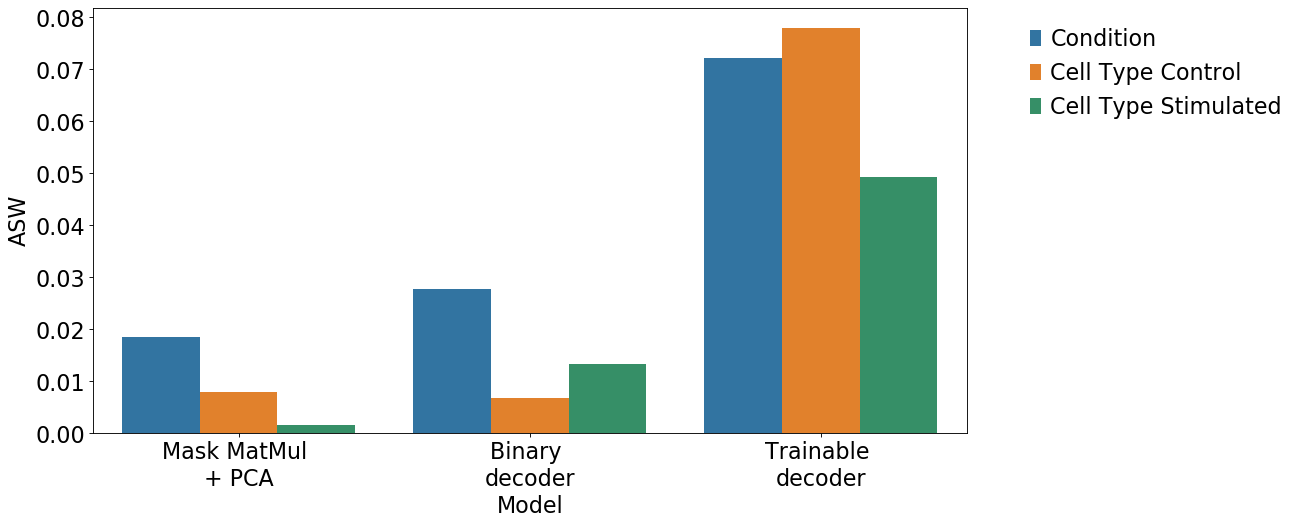

In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=[14,7])
sns.barplot(data=df_res, x='Model', y='ASW', hue='Eval', ax=ax)
ax.grid(False)
ax.set_xlabel('Model',fontsize=20)
ax.set_ylabel('ASW',fontsize=20)
ax.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20, frameon=False, markerscale=2)
ax.tick_params(labelsize=20)
plt.savefig(path_to_save+'asw_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Losses

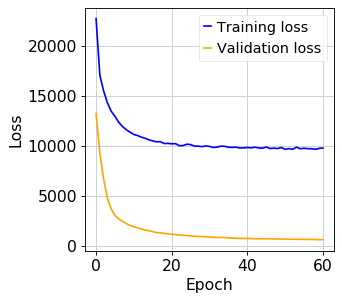

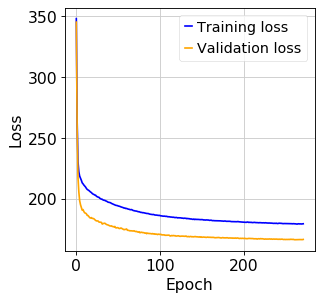

In [7]:
vega.plotting.loss(model_binary)
vega.plotting.loss(model_full)